Acute Toxicity LD50

Dataset Description: Acute toxicity LD50 measures the most conservative dose that can lead to lethal adverse effects. The higher the dose, the more lethal of a drug. 

Task Description: Regression. Given a drug SMILES string, predict its acute toxicity.

Dataset Statistics: 7,385 drugs. 

Dataset is from: https://tdcommons.ai/single_pred_tasks/tox/#acute-toxicity-ld50

Functions are inspired from Dr. Gashaw M_Goshu and Dr. Chanin Nantasenamat

In [1]:
# Import necessary libraries

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from tqdm import tqdm

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


import lazypredict
from lazypredict.Supervised import LazyRegressor


In [2]:
# Fetching dataset from Therapeutic Data Commons
from tdc.single_pred import Tox

data = Tox(name = 'LD50_Zhu')


Found local copy...
Loading...
Done!


In [3]:
split = data.get_split()

In [4]:
split['train'].head()

,Drug_ID,Drug,Y
0,"Methane, tribromo-",BrC(Br)Br,2.34
1,Bromoethene (9CI),C=CBr,2.33
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.47
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.73
4,"Benzene, bromo-",Brc1ccccc1,1.76


In [5]:
len(split['train']) , len(split['valid']) , len(split['test'])

(5170, 738, 1477)

In [6]:
#Concatinating originally splitted data into one dataframe.
train = split['train']

val  = split['valid']

test = split['test']
   
    
df = pd.concat([train, val, test])
df.tail()

,Drug_ID,Drug,Y
1472,"1H-1,2,4-Triazole, 1-((2-(2,4-dichlorophenyl)-...",CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,2.35
1473,"Phosphorothioic acid, O-(3-chloro-4-nitropheny...",CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,3.81
1474,"Dibenz(b,f)oxepin-2-acetic acid, 10,11-dihydro...",Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,2.94
1475,"Phosphorothioic acid, O,O-dimethyl S-(2-(ethyl...",CCS(=O)(=O)CCSP(=O)(OC)OC,3.91
1476,"Cyclopropanecarboxylic acid, 2,2-dimethyl-3-(2...",CC(C)=CC1C(C(=O)OCc2coc(Cc3ccccc3)c2)C1(C)C,3.73


In [7]:
df = df.reset_index(drop= True)
df.tail()

,Drug_ID,Drug,Y
7380,"1H-1,2,4-Triazole, 1-((2-(2,4-dichlorophenyl)-...",CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,2.35
7381,"Phosphorothioic acid, O-(3-chloro-4-nitropheny...",CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,3.81
7382,"Dibenz(b,f)oxepin-2-acetic acid, 10,11-dihydro...",Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,2.94
7383,"Phosphorothioic acid, O,O-dimethyl S-(2-(ethyl...",CCS(=O)(=O)CCSP(=O)(OC)OC,3.91
7384,"Cyclopropanecarboxylic acid, 2,2-dimethyl-3-(2...",CC(C)=CC1C(C(=O)OCc2coc(Cc3ccccc3)c2)C1(C)C,3.73


In [8]:
# renaming the columns names

df= df.rename(columns={"Drug": "Canonical_smiles", "Y": "LD50_toxicity"})

df.head()

,Drug_ID,Canonical_smiles,LD50_toxicity
0,"Methane, tribromo-",BrC(Br)Br,2.34
1,Bromoethene (9CI),C=CBr,2.33
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.47
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.73
4,"Benzene, bromo-",Brc1ccccc1,1.76


In [9]:
len(df)

7385

In [10]:
# Include 2D structure of molecules

from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df,'Canonical_smiles', 'Structure')

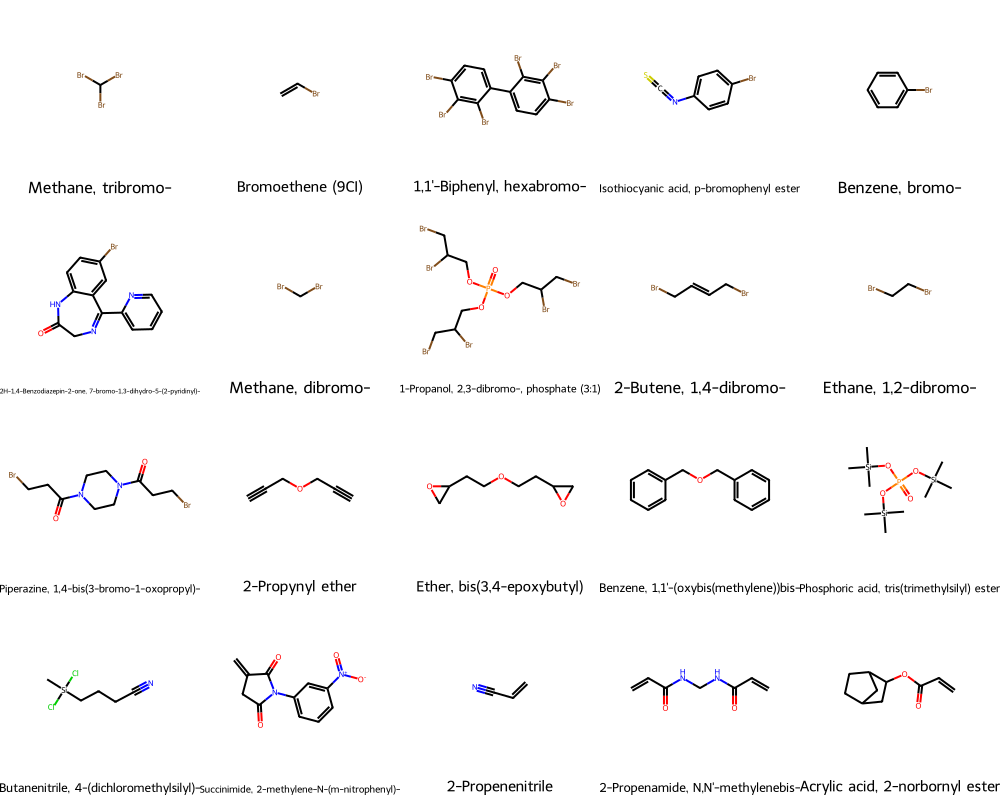

In [11]:
# Drawing some molecules.

from rdkit.Chem import Draw
Draw.MolsToGridImage([x for x in df["Structure"]][:20], maxMols=100, 
                     legends=[str(x) for x in df.Drug_ID], 
                     subImgSize=(200,200), molsPerRow=5)

In [12]:
# Checking for empty data
df.isna().sum()

Drug_ID             0
Canonical_smiles    0
LD50_toxicity       0
Structure           0
dtype: int64

In [13]:
df.head()

,Drug_ID,Canonical_smiles,LD50_toxicity,Structure
0,"Methane, tribromo-",BrC(Br)Br,2.34,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
1,Bromoethene (9CI),C=CBr,2.33,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.47,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.73,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
4,"Benzene, bromo-",Brc1ccccc1,1.76,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...


#### Generate canonical SMILES

In [14]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [15]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(df['Canonical_smiles'])
len(Canon_SMILES)

7385

In [16]:
# Put the smiles in the dataframe
df['Canonical_smiles'] = Canon_SMILES
df.head()

,Drug_ID,Canonical_smiles,LD50_toxicity,Structure
0,"Methane, tribromo-",BrC(Br)Br,2.34,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
1,Bromoethene (9CI),C=CBr,2.33,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.47,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.73,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
4,"Benzene, bromo-",Brc1ccccc1,1.76,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...


In [17]:
# Checking for duplicate smiles 
print( len(df['Canonical_smiles'].unique()) , len(df['Canonical_smiles']))

print()

print(len(df[df['Canonical_smiles'].duplicated()]))

7342 7385

43


In [18]:
# Dropping duplicate values
df = df.drop_duplicates(subset= 'Canonical_smiles' , keep= 'first')
len(df)

7342

In [19]:
df = df.reset_index(drop= True)

### Finding the outlier values

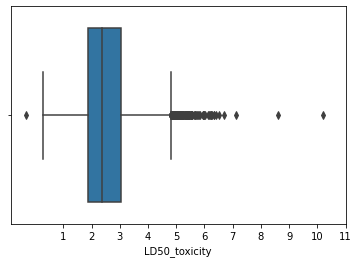

In [20]:
sns.boxplot(df.LD50_toxicity)
plt.xticks(range(1,12));

In [21]:
df[(df['LD50_toxicity'] > 5) | (df['LD50_toxicity'] < 1)]

,Drug_ID,Canonical_smiles,LD50_toxicity,Structure
24,"1,3-Butadiene",C=CC=C,0.99,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
69,Cyclohexane,C1CCCCC1,0.82,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
75,"1,3,5-Triazine, 2,4,6-tris(1-aziridinyl)-",C1CN1c1nc(N2CC2)nc(N2CC2)n1,5.31,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
239,"Trichothec-9-ene-3,4,8,15-tetrol, 12,13-epoxy-...",CC(=O)OCC12CC(OC(=O)CC(C)C)C(C)=CC1OC1C(O)C(OC...,5.24,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
261,"1-Butanol, 3-methyl-, acetate",CC(=O)OCCC(C)C,0.89,<rdkit.Chem.rdchem.Mol object at 0x000002F1DDA...
...,...,...,...,...
7266,"1,3-Dithiolane-2,4-dione, 5,5-dimethyl-, 2-(di...",CNC(=O)ON=C1SC(=NN(C)C)SC1(C)C,5.19,<rdkit.Chem.rdchem.Mol object at 0x000002F1E2C...
7267,"1,4-Dithian-2-one, 3-methyl-, O-((methylamino)...",CNC(=O)ON=C1SCCSC1C,5.00,<rdkit.Chem.rdchem.Mol object at 0x000002F1E2C...
7281,"Benzimidazole-6-carbonitrile, 4-chloro-2-(trif...",N#Cc1cc(Cl)c2nc(C(F)(F)F)[nH]c2c1,5.01,<rdkit.Chem.rdchem.Mol object at 0x000002F1E2C...
7298,"1,3-Dithiolan-4-one, 2,2-dimethyl-, O-((methyl...",CNC(=O)ON=C1CSC(C)(C)S1,5.04,<rdkit.Chem.rdchem.Mol object at 0x000002F1E2C...


In [22]:
outliers = df[(df['LD50_toxicity'] > 3.5) | (df['LD50_toxicity'] < 1)].index

outliers

Int64Index([  24,   50,   69,   75,  111,  131,  145,  147,  153,  169,
            ...
            7284, 7285, 7298, 7299, 7300, 7304, 7321, 7332, 7339, 7341],
           dtype='int64', length=1233)

In [23]:
df_no_outlier = df.drop(outliers , axis=0)

<AxesSubplot:xlabel='LD50_toxicity'>

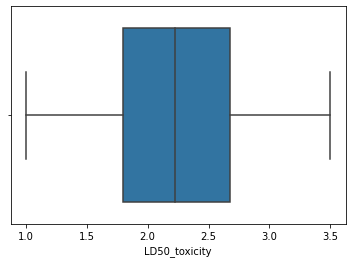

In [24]:
sns.boxplot(df_no_outlier.LD50_toxicity)

In [25]:
# df = df_no_outlier
# df = df.reset_index(drop= True)
# df.tail()

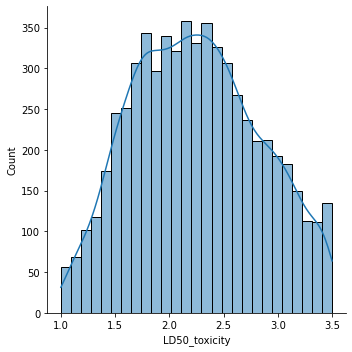

In [26]:
# Distrution of toxicity with no outliers.
sns.displot(data= df_no_outlier, x= 'LD50_toxicity' , kde = True);

In [27]:
#### Removing outlierd didm't imporove the performance of the models.

In [48]:
# Generate MACCS (Molecular ACCess System) keys
from rdkit.Chem.MACCSkeys import GenMACCSKeys

# Generate Morgan fingerprints
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Generate  RDKit fingerprints
from rdkit.Chem.AllChem import RDKFingerprint

# Calculate Avalon fingerprints
from rdkit.Avalon import pyAvalonTools

# Calculate Atom-Pair fingerprints
from rdkit.Chem.rdMolDescriptors import GetHashedAtomPairFingerprintAsBitVect

# Calculate Topological-Torsions fingerprints
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect



In [40]:
def generate_fpts(data):
    # create empty lists to store fingerprints
    
   # MACCS fingerprint
    MACCS_fingerprint = []

    # Morgan fingerprint
    Morgan_fingerprint = []
    
    # RDKit fingerprint
    RDKit_fingerprint = []
    
    # Avalon fingerprint
    Avalon_fingerprint = []
    
    # Atom-Pair fingerprint
    Atom_Pair = []
    
    # Topological Torsion fingerprint
    Topological_torsion_fingerprint = []
    
    for mol in tqdm(data):
        
       # Calculate MACCS fingerprints
        maccs = MACCSkeys.GenMACCSKeys(mol)
        MACCS_fingerprint.append(maccs)

       # Calculate RDkit fingerprints
        rdk = RDKFingerprint(mol, fpSize=1024)
        RDKit_fingerprint.append(rdk)
        
        # Calculate Morgan fingerprints 
        mfpt = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        Morgan_fingerprint.append(mfpt)
        
        # Calculate Avalon fingerprints 
        Avfpt = pyAvalonTools.GetAvalonFP(mol, nBits=1024)
        Avalon_fingerprint.append(Avfpt)
        
        atom_pair = GetHashedAtomPairFingerprintAsBitVect(mol, nBits=1024)
        Atom_Pair.append(atom_pair)
        
        #calculate TopologicalTorsion fingerprints 
        TT_fpt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=1024)
        Topological_torsion_fingerprint.append(TT_fpt)
        
        MACCS_fingerprint = np.array(MACCS_fingerprint)
        RDKit_fingerprint = np.array(RDKit_fingerprint)
        Morgan_fingerprint = np.array(Morgan_fingerprint)
        Avalon_fingerprint = np.array(Avalon_fingerprint)
        Atom_Pair = np.array(Atom_Pair)
        Topological_torsion_fingerprint = np.array(Topological_torsion_fingerprint)
        
       # dataframe= pd.concat([MACCS_fingerprint, RDKit_fingerprint, Morgan_fingerprint, Avalon_fingerprint, Atom_Pair, Topological_torsion_fingerprint], axis=1)
        
#         return MACCS_fingerprint, RDKit_fingerprint, Morgan_fingerprint, Avalon_fingerprint, Atom_Pair, Topological_torsion_fingerprint

        return Morgan_fingerprint, Avalon_fingerprint,Topological_torsion_fingerprint

In [55]:

def generate_MACCS_fingerprint(data):
    
    MACCS = [GenMACCSKeys(mol) for mol in data]
        
    return np.array(MACCS)


def generate_RDKit_fingerprint(data):
    
    RDKit = [RDKFingerprint(mol, fpSize=512) for mol in data]
        
    return np.array(RDKit)


def generate_morgan_fingerprint(data):
    
    morgan = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512) for mol in data]
        
    return np.array(morgan)


def generate_avalon_fingerprint(data):
    
    Avfpts = [pyAvalonTools.GetAvalonFP(mol, nBits=512) for mol in data]
        
    return np.array(Avfpts)


def generate_atompair_fingerprint(data):
    
    atompair = [GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512) for mol in data]
        
    return np.array(atompair)


def generate_TopologicalTorsion_fingerprint(data):
    
    TopologicalTorsion = [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=512) for mol in data]
        
    return np.array(TopologicalTorsion)


In [66]:
MACCS = pd.DataFrame(generate_MACCS_fingerprint(df.Structure))
rdkit = pd.DataFrame(generate_RDKit_fingerprint(df.Structure))
morgan = pd.DataFrame(generate_morgan_fingerprint(df.Structure))
Avalon_fpts = pd.DataFrame(generate_avalon_fingerprint(df.Structure))
atompair = pd.DataFrame(generate_atompair_fingerprint(df.Structure))
torsions = pd.DataFrame(generate_TopologicalTorsion_fingerprint(df.Structure))

In [67]:
MACCS.shape, rdkit.shape, morgan.shape, Avalon_fpts.shape , atompair.shape, torsions.shape

((7342, 167), (7342, 512), (7342, 512), (7342, 512), (7342, 512), (7342, 512))

In [68]:
descriptors = pd.concat([MACCS, rdkit, morgan, Avalon_fpts, atompair, torsions], axis=1)

In [69]:
descriptors= descriptors.T.reset_index(drop=True).T
descriptors

,0,1,2,3,4,5,6,7,8,9,...,2717,2718,2719,2720,2721,2722,2723,2724,2725,2726
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7338,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7339,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [70]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(np.bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
   
    return descriptors_correlated_dropped  

In [71]:
descriptors_new = remove_correlated_features(descriptors)
descriptors_new.shape

[40, 56, 58, 60, 61, 70, 88, 96, 105, 117, 134, 143, 147, 712, 759, 862, 973, 1405, 1542, 2264, 2470]


(7342, 2706)

In [72]:
descriptors_new.to_csv('Descriptors.csv', index= False)

In [73]:
descriptors_new = pd.read_csv('Descriptors.csv')

In [74]:
from sklearn.feature_selection import VarianceThreshold

# def remove_low_variance(input_data, threshold=0.1):
#     selection = VarianceThreshold(threshold)
#     selection.fit(input_data)
#     return input_data[input_data.columns[selection.get_support(indices=True)]]



from sklearn.feature_selection import VarianceThreshold

selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))    
X = selection.fit_transform(descriptors_new)

In [75]:
# X = remove_low_variance(descriptors_new, threshold=0.9)
#X = X.reset_index(drop= True)
X.shape

(7342, 1013)

In [76]:
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7337,0,0,0,0,0,1,0,1,1,0,...,1,1,0,1,1,1,1,1,0,0
7338,0,0,0,1,1,1,0,1,0,0,...,1,0,0,1,1,1,1,0,0,1
7339,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,0,1,0,1,1
7340,0,1,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,0,1


In [77]:

target = pd.Series(df['LD50_toxicity'])
pd.DataFrame(target)

,LD50_toxicity
0,2.34
1,2.33
2,1.47
3,2.73
4,1.76
...,...
7337,2.96
7338,2.35
7339,3.81
7340,2.94


In [78]:
df_final = pd.concat([X , target] , axis= 1)

In [79]:
df_final = df_final.reset_index(drop= True)

In [80]:
# Assign Features and Labels

X = df_final.drop('LD50_toxicity' , axis= 1)
y = df_final['LD50_toxicity'] # labels or targets

len(X) , len(y)

(7342, 7342)

In [81]:
# Train-test data split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5139, 1013), (2203, 1013), (5139,), (2203,))

In [82]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012
3532,0,0,1,1,1,1,0,0,0,1,...,0,0,1,1,0,0,1,1,0,0
2521,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7183,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0,0,0,1,1,1,1,0,0,1,...,0,0,0,1,0,0,1,1,1,1
5226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
5390,1,0,1,0,0,0,0,1,1,0,...,1,0,0,1,1,1,1,1,0,0
860,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [83]:
pd.DataFrame(y_train)

,LD50_toxicity
3532,3.13
2521,2.31
7183,4.29
5617,1.67
613,2.44
...,...
5191,2.65
5226,2.59
5390,3.04
860,2.50


In [84]:
from sklearn.preprocessing import StandardScaler


# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### Building the prediction model.

In [85]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PoissonRegressor


from sklearn.ensemble     import RandomForestRegressor
from sklearn.ensemble     import ExtraTreesRegressor
from sklearn.ensemble     import AdaBoostRegressor
from sklearn.ensemble     import GradientBoostingRegressor
from sklearn.ensemble     import HistGradientBoostingRegressor
from sklearn.ensemble     import BaggingRegressor

from lightgbm             import LGBMRegressor
from sklearn.compose      import TransformedTargetRegressor

from sklearn.tree         import DecisionTreeRegressor
from sklearn.svm          import SVR
from sklearn.neighbors    import KNeighborsRegressor
from xgboost              import XGBRegressor
from sklearn.neural_network import MLPRegressor

models= {"Linear Model": ElasticNet(),
         #"SGDRegressor": SGDRegressor(),
         #"PoissonRegressor": PoissonRegressor(),
         "Random Forest Regressor": RandomForestRegressor(),
         "ExtraTreesRegressor": ExtraTreesRegressor(),
         "AdaBoostRegressor": AdaBoostRegressor(),
         "GradientBoostingRegressor": GradientBoostingRegressor(),
         "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
         "BaggingRegressor": BaggingRegressor(),
         "LGBMRegressor": LGBMRegressor(),
         "TransformedTargetRegressor": TransformedTargetRegressor(),
         "Decision Tree Regressor": DecisionTreeRegressor(),
         "Support Vector Regressor": SVR(),
         "KNN Regressor": KNeighborsRegressor(),
         "XGBRegressor": XGBRegressor(),
         "MLPRegressor": MLPRegressor() }


In [86]:
from sklearn.metrics import mean_absolute_error


def classify (models , X_train , X_test , y_train , y_test):
    
    model_scores= {}
    
    for name , model in models.items():

        model.fit(X_train , y_train)
        
        y_pred= model.predict(X_test)
        
    
        model_scores[name]= r2_score(y_test , y_pred)
        
    return model_scores



In [87]:
model_scores= classify(models=models,
                      X_train= X_train,
                      X_test= X_test,
                      y_train= y_train,
                      y_test= y_test)

model_scores

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 5139, number of used features: 1013
[LightGBM] [Info] Start training from score 2.545801


{'Linear Model': -0.00011220471810902133,
 'Random Forest Regressor': 0.5912631959523031,
 'ExtraTreesRegressor': 0.18148877483330195,
 'AdaBoostRegressor': 0.32445000005656566,
 'GradientBoostingRegressor': 0.5152745300452617,
 'HistGradientBoostingRegressor': 0.5936866237939273,
 'BaggingRegressor': 0.5368896571974229,
 'LGBMRegressor': 0.5883439726929302,
 'TransformedTargetRegressor': 0.41463451215108404,
 'Decision Tree Regressor': 0.06458092845703922,
 'Support Vector Regressor': 0.5928028742214486,
 'KNN Regressor': 0.5448283890119264,
 'XGBRegressor': 0.5633885254805617,
 'MLPRegressor': 0.37943541930365543}

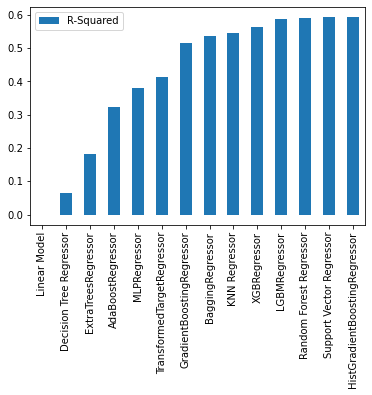

In [88]:
models_compare= pd.DataFrame(model_scores , index=['R-Squared'])

models_compare.T.sort_values(by= ['R-Squared']).plot.bar();

In [94]:
model_2 = HistGradientBoostingRegressor()

model_2.fit(X_train, y_train)

preds_2 = model_2.predict(X_test)

r2_score(y_test , preds_2)

0.5936866237939273

In [89]:
from sklearn.model_selection import GridSearchCV

model_3 = HistGradientBoostingRegressor()

param_grid={'learning_rate': [0.01, 0.1],
            'max_iter': [100, 200],
            'max_leaf_nodes': [31, 50],
            'max_depth': [5,10],
            'min_samples_leaf': [20, 30],
            'l2_regularization': [0.0, 0.1]} 


hgb_gs = GridSearchCV(
    estimator=model_3,
    param_grid= param_grid,
    n_jobs=-1)

hgb_gs.fit(X_train, y_train)

GridSearchCV(estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 0.1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [5, 10],
                         'max_iter': [100, 200], 'max_leaf_nodes': [31, 50],
                         'min_samples_leaf': [20, 30]})

In [91]:
hgb_gs.best_estimator_

HistGradientBoostingRegressor(max_depth=10, max_iter=200, max_leaf_nodes=50)

In [90]:
preds_3 = hgb_gs.predict(X_test)

r2_score(y_test , preds_3)

0.6100139731696528

#### Scatter Plot of Experimental vs Predicted pIC50 Values.

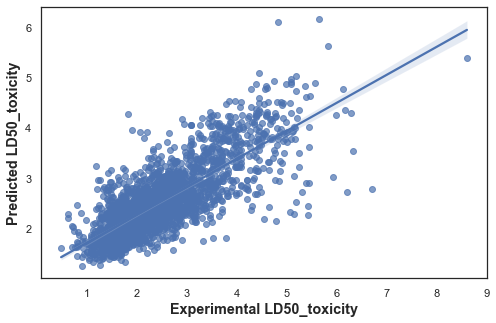

In [95]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(y_test, preds_2, scatter_kws={'alpha':0.7})
ax.set_xlabel('Experimental LD50_toxicity', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted LD50_toxicity', fontsize='large', fontweight='bold')
ax.figure.set_size_inches(8 , 5)
plt.show()

In [97]:
df_ = pd.DataFrame()


df_['Actual'] = np.array(y_test)
df_['Predicted'] = preds_2


df_[:20]

,Actual,Predicted
0,1.45,2.91
1,2.74,3.62
2,2.35,2.56
3,2.39,2.26
4,2.96,2.40
5,4.73,3.55
6,1.47,1.49
7,1.47,2.91
8,2.20,2.59
9,2.84,2.61


#### Fine-tuning exreatree regressor using GridSearchCV.

In [53]:
# from sklearn.model_selection import GridSearchCV

# model = ExtraTreesRegressor()

# param_grid={
#         'n_estimators': range(50,201,50),   
#         'min_samples_leaf': [2 , 4 , 8],
#         'min_samples_split': [2 , 4 , 8],
#         'max_depth': [2,4,8] }


# extrtree_gsc = GridSearchCV(
#     estimator=model,
#     param_grid= param_grid,
#     scoring='r2',
#     n_jobs=-1)


# extrtree_gsc_result = extrtree_gsc.fit(X_train, y_train)

In [54]:
#  extrtree_gsc_result.best_params_

In [55]:
# GridSearchCV did't make any improvement on ExtraTreesRegressor.

In [56]:
# model_gs = ExtraTreesRegressor(n_estimators= 200,
#                               max_depth = 8,
#                               min_samples_leaf = 2,
#                               min_samples_split = 2,
#                               )

# result = model.fit(X_train, y_train)

# preds = model.predict(X_test)

# r2_score(y_test , preds)

#### Saving and loading the model.

In [98]:
import pickle

with open('HistGradientBoostingRegressor.pkl','wb') as f:
          pickle.dump(model_2,f)


In [ ]:
# with open('ExtraTree_Model.pkl','rb') as f:
#     model = pickle.load(f)